### Em 20-06-2017 foram finalizados testes com modelo SVM de kernel rbf para predição vazio/não vazio. Este é o relatório
Os testes iniciais foram promissores. Foram selecionados pelo script ExportaConteinerTipo até 200 contêineres de cada tipo e capacidade e separados em pastas no formato vazio/20/tipoXXX, vazio/40/tipoXXX, naovazio/20/tipoXXX, naovazio/40/tipoXXX, resultando em 2238 contêineres vazios e 2896 contêineres não vazios,imagens normalizadas de 0 a 1 e redimensionadas para 128 x 128.

Foi treinado, através de GridSearchCV, um classificador SVM com kernel rbf, separando 25% dos dados para base de validação. 
Precisão(vazio-vazio) de 98%, recall(naovazio-naovazio) de 100%. Foram identificadas e excluídas imagens de vazio que realmente eram de não vazios (erro de base). Rodando novamente, precisão 99.38%, recall 100% no teste e 100%-100% no treinamento. De 596 imagens, 8 foram "erroneamente" classificadas como não vazias. São imagens que possuem estutura e até mesmo interior do contêiner mais "escuros" e sendo difícil de determinar até mesmo visualmente se estão ou não vazios com 100% de certeza. (Detalhes abaixo)

Em seguida, foi realizada validação cruzada em 5 partes (StratifiedKFold n_splits=5) - precisão média (Detalhes abaixo)

Por último, foram extraídos da base de dados de testes do sistema Virasana (440.000 imagens de escâner da ALF-STS, de 01-07 a 31-10-2017) as imagens que haviam sido classificadas erroneamente pelo classificador de vazio anterior. São imagens que podem ser consideradas como de classificação mais "difícil".

Para validar melhora em relação ao modelo anterior:

Primeiro, checar erro tipo I (precisão) - Rótulo 1 previsto para rótulo "correto"(declarado) 0. (1580 imagens)

Após, checar erro tipo II (recall) - Rótulo previsto como 0 e declarado como 1 (1742 imagens)

Com relação aos contêineres vazios, das 1540 imagens erroneamente classificadas erroneamente pelo algoritmo anterior, apenas 54 continuaram sendo classificadas como não vazias pelo novo algoritmo. Visualizando os 54 "erros" notou-se que eram erros de base, as imagens não eram de vazios. Portanto, em relação ao algoritmo anterior, houve grande mudança, passando a classificar como vazios mais de 1500 imagens classificadas como não vazios pelo algoritmo anterior.

Com relação aos contêineres não vazios, 1742 imagens estavam, teoricamente, sendo classificadas erradamente como vazios. Neste caso, 1336 imagens continuaram sendo classificadas como vazios apesar do rótulo naovazio na base. Inspecionando visualmente as primeiras 128 imagens, nota-se que mais de 80% são realmente naovazios, embora com muito pouca carga. O restante parece ser realmente conteiner vazio com rótulo errado na base (poderia ser contêiner com carga como espuma, muito pouco densa).

Conclui-se que, apesar do algoritmo ser promissor (simples, pouco custoso computacionalmente e com bons resultados), a base introduziu um viés de alta sensibilidade no 0 - vazio - negativo, e baixa sensibilidade no 1 - naovazio - positivo. Mas, no problema que está sendo proposto, é melhor ter sensibilidade no positivo - naovazio, mesmo que siginifique uma maior taxa de falso positivos que gerem inspeção visual.

Assim, no final deste notebook, foram exportadas para pasta "naovaziosdificeis" as imagens do teste tipo II e para pasta "vaziosdificeis" as imagens do teste tipo I. Serão excluídas as imagens desta pasta que pareçam ser de vazios e será rodado novo treinamento incluindo estas imagens na base para tentar aumentar a sensibilidade do positivo.


In [1]:
import random
import os
from collections import defaultdict
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.externals import joblib
from sklearn import metrics, model_selection, svm

In [2]:
def walk(dir_name):
    names = []
    for dirpath, dirnames, filenames in os.walk(dir_name):
        for filename in filenames:
            names.append(os.path.join(dirpath, filename))
    return names
        
vazios = walk('vazios')
naovazios = walk('naovazios')


In [3]:
print(len(vazios))
print(vazios[:5])
print(len(naovazios))
print(naovazios[:5])

2338
['vazios/40/high_cube_flat_coll._flush_fold4096/5aa1d2372a879501d48cbf88.jpg', 'vazios/40/high_cube_flat_coll._flush_fold4096/5aa1d2382a879501d48cbf90.jpg', 'vazios/40/high_cube_flat_coll._flush_fold4096/5aa1d2382a879501d48cbf94.jpg', 'vazios/40/high_cube_flat_coll._flush_fold4096/5aa1d2362a879501d48cbf7c.jpg', 'vazios/40/high_cube_flat_coll._flush_fold4096/5aa1d2372a879501d48cbf8c.jpg']
2896
['naovazios/40/tank_gases_22.0_bar(4086)/5aa18b6f2a87953d800294d1.jpg', 'naovazios/40/high_cube_flat_coll._flush_fold4096/5aa1b6d12a87955d1d842747.jpg', 'naovazios/40/general_purpose_(passive_vents)(4086)/5aa1a7952a87954aaeddb8a9.jpg', 'naovazios/40/general_purpose_(passive_vents)(4086)/5aa18b752a87953d7e029c0a.jpg', 'naovazios/40/general_purpose_(passive_vents)(4086)/5aa18c892a87953ebf575833.jpg']


In [4]:

def view_images(imagens):
    # imagens: tuple(str, PIL.Image)
    plt.gray()
    fig=plt.figure(figsize=(16, 20))
    columns = 4
    rows = 4
    for i in range(1, columns*rows +1):
        img = imagens[i - 1][1]
        title = imagens[i - 1][0]
        title = '-'.join(title.split('/')[1:-1])
        # print(title)
        ax = fig.add_subplot(rows, columns, i)
        ax.set_title(title)
        plt.imshow(img)
    plt.show()

<Figure size 432x288 with 0 Axes>

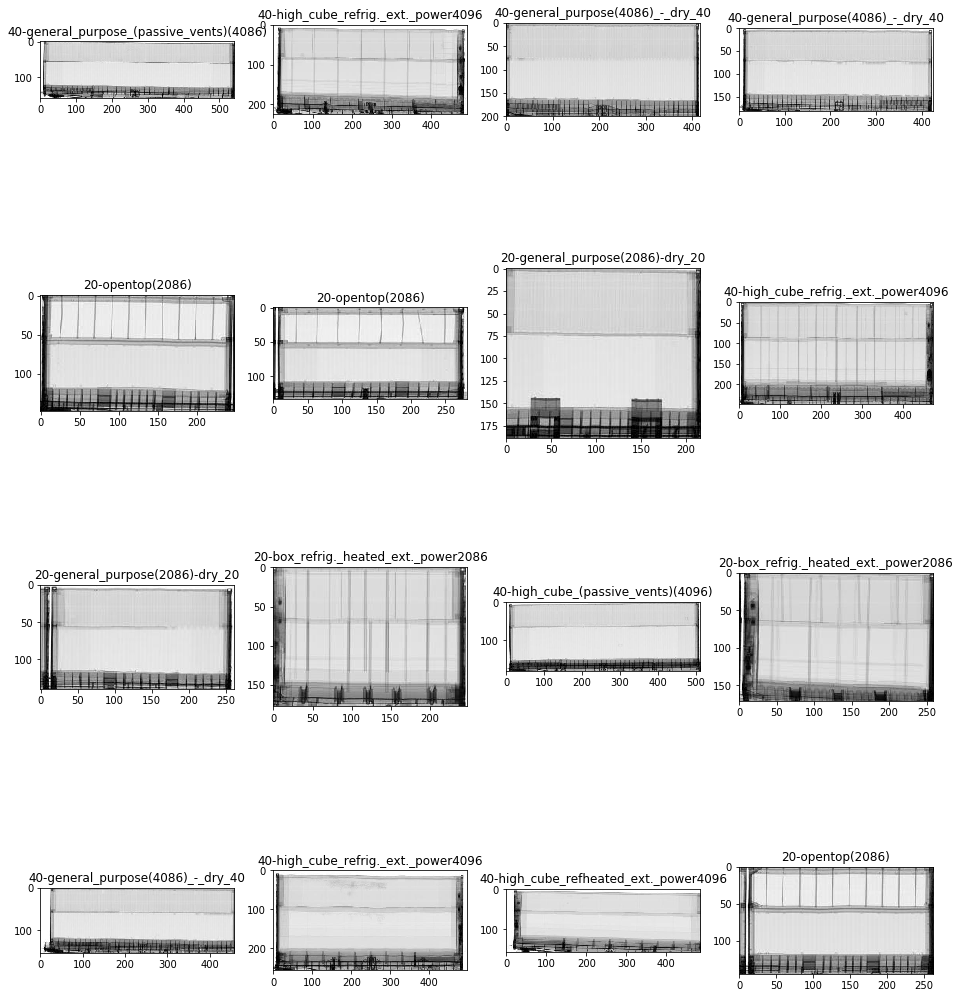

In [5]:
indexes = np.random.randint(0, len(vazios), 16)
imagens = [(vazios[index], Image.open(vazios[index])) for index in indexes]
view_images(imagens)

<Figure size 432x288 with 0 Axes>

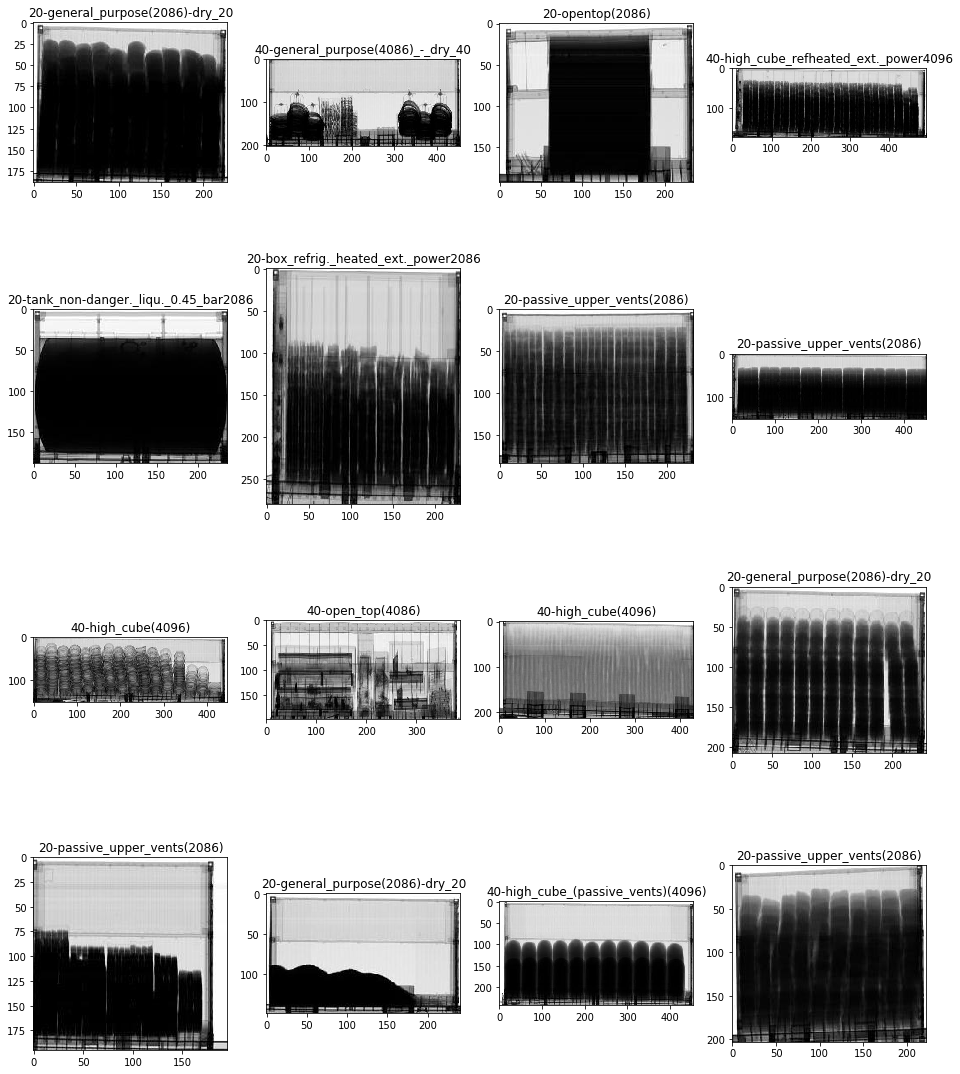

In [6]:
indexes = np.random.randint(0, len(naovazios) + 1, 16)
imagens = [(naovazios[index], Image.open(naovazios[index])) for index in indexes]
view_images(imagens)

In [7]:
SIZE = 128, 128

def image_array(filenames):
    result = []
    for filename in filenames:
        image = Image.open(filename)
        image = image.resize(SIZE, Image.ANTIALIAS)
        image_array = np.asarray(image).astype('float32')
        image_array = image_array[:, :, 0] / 255
        del image
        result.append(image_array)
    return result


In [8]:
npvazios = np.asarray(image_array(vazios))
npvazios = np.reshape(npvazios, (npvazios.shape[0], npvazios.shape[1] * npvazios.shape[2]))
npvazios.shape

(2338, 16384)

In [9]:
npnaovazios = np.asarray(image_array(naovazios))
npnaovazios = np.reshape(npnaovazios, (npnaovazios.shape[0], npnaovazios.shape[1] * npnaovazios.shape[2]))
npnaovazios.shape

(2896, 16384)

In [10]:
import pandas as pd
dfv = pd.DataFrame(npvazios)
dfnaov = pd.DataFrame(npnaovazios)

In [11]:
dfv['y'] = 0
dfnaov['y'] = 1

In [12]:
dfv.head()

,0,1,2,3,4,5,6,7,8,9,...,16375,16376,16377,16378,16379,16380,16381,16382,16383,y
0,0.858824,0.407843,0.545098,0.992157,0.972549,0.984314,0.992157,0.992157,0.992157,0.984314,...,0.725490,0.694118,0.678431,0.709804,0.756863,0.796078,0.749020,0.286275,0.670588,0
1,0.988235,0.984314,0.988235,0.996078,0.992157,0.992157,0.996078,0.996078,0.996078,0.996078,...,0.541176,0.400000,0.803922,0.658824,0.725490,0.223529,0.137255,0.094118,0.729412,0
2,1.000000,0.717647,0.388235,0.796078,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.678431,0.674510,0.709804,0.443137,0.027451,0.223529,0.254902,0.764706,1.000000,0
3,0.996078,0.996078,0.996078,0.988235,1.000000,0.756863,0.294118,0.447059,0.650980,0.721569,...,0.435294,0.466667,0.458824,0.415686,0.388235,0.494118,0.572549,0.458824,0.345098,0
4,0.980392,0.949020,0.901961,0.976471,0.980392,0.984314,0.988235,0.988235,0.996078,0.984314,...,0.611765,0.541176,0.541176,0.552941,0.666667,0.603922,0.450980,0.070588,0.156863,0


In [13]:
dfnaov.head()

,0,1,2,3,4,5,6,7,8,9,...,16375,16376,16377,16378,16379,16380,16381,16382,16383,y
0,0.988235,1.000000,1.000000,0.992157,1.000000,0.996078,0.992157,0.996078,0.996078,0.996078,...,0.368627,0.219608,0.168627,0.266667,0.258824,0.258824,0.282353,0.243137,0.239216,1
1,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,1.000000,1.000000,0.992157,...,0.666667,0.670588,0.576471,0.568627,0.698039,0.549020,0.588235,0.654902,0.498039,1
2,0.996078,0.996078,0.984314,1.000000,0.627451,0.607843,0.984314,0.988235,0.988235,0.988235,...,0.568627,0.572549,0.462745,0.549020,0.015686,0.039216,0.847059,1.000000,0.988235,1
3,0.600000,0.647059,0.647059,0.729412,0.733333,0.725490,0.725490,0.733333,0.749020,0.733333,...,0.556863,0.537255,0.564706,0.419608,0.019608,0.000000,0.760784,1.000000,0.984314,1
4,0.549020,0.705882,1.000000,0.956863,0.956863,0.952941,0.941176,0.937255,0.941176,0.921569,...,0.698039,0.701961,0.721569,0.694118,0.556863,0.349020,0.423529,0.156863,0.050980,1


In [14]:
df = pd.concat([dfv, dfnaov])
df['_ids'] = vazios + naovazios
len(df)

5234

In [15]:
df.iloc[:5]

,0,1,2,3,4,5,6,7,8,9,...,16376,16377,16378,16379,16380,16381,16382,16383,y,_ids
0,0.858824,0.407843,0.545098,0.992157,0.972549,0.984314,0.992157,0.992157,0.992157,0.984314,...,0.694118,0.678431,0.709804,0.756863,0.796078,0.749020,0.286275,0.670588,0,vazios/40/high_cube_flat_coll._flush_fold4096/...
1,0.988235,0.984314,0.988235,0.996078,0.992157,0.992157,0.996078,0.996078,0.996078,0.996078,...,0.400000,0.803922,0.658824,0.725490,0.223529,0.137255,0.094118,0.729412,0,vazios/40/high_cube_flat_coll._flush_fold4096/...
2,1.000000,0.717647,0.388235,0.796078,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.674510,0.709804,0.443137,0.027451,0.223529,0.254902,0.764706,1.000000,0,vazios/40/high_cube_flat_coll._flush_fold4096/...
3,0.996078,0.996078,0.996078,0.988235,1.000000,0.756863,0.294118,0.447059,0.650980,0.721569,...,0.466667,0.458824,0.415686,0.388235,0.494118,0.572549,0.458824,0.345098,0,vazios/40/high_cube_flat_coll._flush_fold4096/...
4,0.980392,0.949020,0.901961,0.976471,0.980392,0.984314,0.988235,0.988235,0.996078,0.984314,...,0.541176,0.541176,0.552941,0.666667,0.603922,0.450980,0.070588,0.156863,0,vazios/40/high_cube_flat_coll._flush_fold4096/...


In [16]:
df.iloc[2500:2505]

,0,1,2,3,4,5,6,7,8,9,...,16376,16377,16378,16379,16380,16381,16382,16383,y,_ids
162,0.980392,1.000000,0.803922,0.619608,0.631373,0.631373,0.752941,0.741176,0.749020,0.737255,...,0.054902,0.113725,0.090196,0.000000,0.290196,0.298039,0.074510,0.745098,1,naovazios/40/general_purpose_(passive_vents)(4...
163,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,...,0.301961,0.615686,0.572549,0.576471,0.580392,0.564706,0.215686,0.360784,1,naovazios/40/general_purpose_(passive_vents)(4...
164,1.000000,0.588235,0.396078,0.627451,0.764706,0.764706,0.768627,0.752941,0.752941,0.741176,...,0.760784,0.713726,0.639216,0.588235,0.572549,0.439216,0.243137,0.066667,1,naovazios/40/general_purpose_(passive_vents)(4...
165,0.411765,0.611765,0.717647,0.803922,0.827451,0.831373,0.831373,0.831373,0.835294,0.831373,...,0.576471,0.580392,0.572549,0.588235,0.580392,0.592157,0.568627,0.352941,1,naovazios/40/general_purpose_(passive_vents)(4...
166,0.996078,1.000000,0.996078,0.992157,0.996078,0.992157,0.992157,0.996078,1.000000,0.992157,...,0.380392,0.223529,0.313726,0.207843,0.109804,0.035294,0.141176,0.901961,1,naovazios/40/general_purpose_(passive_vents)(4...


In [17]:
df.iloc[3500:3505]

,0,1,2,3,4,5,6,7,8,9,...,16376,16377,16378,16379,16380,16381,16382,16383,y,_ids
1162,0.478431,0.549020,0.631373,0.701961,0.788235,0.756863,0.705882,0.764706,0.788235,0.768627,...,0.564706,0.572549,0.360784,0.239216,0.407843,0.341176,0.333333,0.050980,1,naovazios/40/high_cube_refrig._self_power4096/...
1163,1.000000,0.682353,0.321569,0.282353,0.466667,0.596078,0.635294,0.643137,0.654902,0.666667,...,0.035294,0.035294,0.031373,0.062745,0.000000,0.035294,0.894118,1.000000,1,naovazios/40/high_cube_refrig._self_power4096/...
1164,0.996078,0.996078,0.988235,1.000000,0.768627,0.215686,0.439216,0.686275,0.760784,0.788235,...,0.105882,0.082353,0.082353,0.090196,0.137255,0.156863,0.184314,0.054902,1,naovazios/40/high_cube_refrig._self_power4096/...
1165,0.980392,0.984314,0.984314,0.996078,1.000000,0.996078,0.988235,0.996078,0.996078,1.000000,...,0.129412,0.086275,0.098039,0.109804,0.121569,0.078431,0.066667,0.047059,1,naovazios/40/high_cube_refrig._self_power4096/...
1166,1.000000,0.674510,0.423529,0.509804,0.623529,0.690196,0.788235,0.776471,0.772549,0.772549,...,0.345098,0.176471,0.094118,0.015686,0.000000,0.545098,0.996078,0.988235,1,naovazios/40/high_cube_refrig._self_power4096/...


In [18]:
X = df[df.columns[:-2]]
X.head()

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.858824,0.407843,0.545098,0.992157,0.972549,0.984314,0.992157,0.992157,0.992157,0.984314,...,0.666667,0.725490,0.694118,0.678431,0.709804,0.756863,0.796078,0.749020,0.286275,0.670588
1,0.988235,0.984314,0.988235,0.996078,0.992157,0.992157,0.996078,0.996078,0.996078,0.996078,...,0.670588,0.541176,0.400000,0.803922,0.658824,0.725490,0.223529,0.137255,0.094118,0.729412
2,1.000000,0.717647,0.388235,0.796078,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.701961,0.678431,0.674510,0.709804,0.443137,0.027451,0.223529,0.254902,0.764706,1.000000
3,0.996078,0.996078,0.996078,0.988235,1.000000,0.756863,0.294118,0.447059,0.650980,0.721569,...,0.423529,0.435294,0.466667,0.458824,0.415686,0.388235,0.494118,0.572549,0.458824,0.345098
4,0.980392,0.949020,0.901961,0.976471,0.980392,0.984314,0.988235,0.988235,0.996078,0.984314,...,0.549020,0.611765,0.541176,0.541176,0.552941,0.666667,0.603922,0.450980,0.070588,0.156863


In [19]:
y = df['y']
_ids = df['_ids']
print(len(X),len(y), len(_ids))

5234 5234 5234


In [20]:
X_train, X_test, y_train, y_test, _ids_train, _ids_test = \
    model_selection.train_test_split(X, y, _ids,
                                     test_size=.25,
                                     random_state=0)

## A parte de treinamento abaixo é a mais lenta. Se desejado, pode ser pulado e ir direto para a parte que carrega modelo gravado treinado anteriormente

In [27]:
param_grid = [
  {'C': [10, 100, 1000], 'gamma': [1e-3, 1e-4, 1e-5], 'kernel': ['rbf']},
 ]
from sklearn.model_selection import GridSearchCV
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)

In [28]:
clf.fit(X_train[:500], y_train[:500])

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001, 1e-05], 'C': [10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
clf.best_params_

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

In [45]:
svm_estimator = svm.SVC(C=10).fit(X_train, y_train)
# kernel="rbf", C=, gamma=

In [46]:
import time
s0 = time.time()
y_pred = svm_estimator.predict(X_test)
# y_pred = clf.predict(X_test)
elapsed = time.time() - s0
print('%f segundos decorridos para %d registros(%f por registro)' %
     (elapsed, len(y_pred), (elapsed / len(y_pred))))

4.290016 segundos decorridos para 1309 registros(0.003277 por registro)


In [47]:
metrics.confusion_matrix(y_test, y_pred)
# array([[588,   0],
#       [  9, 712]])

array([[588,   0],
       [  9, 712]])

In [48]:
metrics.accuracy_score(y_test, y_pred)
# 0.9938884644766998

0.9931245225362872

In [49]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       588
          1       1.00      0.99      0.99       721

avg / total       0.99      0.99      0.99      1309



In [51]:
y_pred_train = svm_estimator.predict(X_train)
print(metrics.classification_report(y_train, y_pred_train))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1750
          1       1.00      0.99      0.99      2175

avg / total       0.99      0.99      0.99      3925



In [52]:
error_indexes = []
for index, (yt, y_, _id) in enumerate(zip(y_test, y_pred, _ids_test)):
    if yt != y_:
        print('Linha %d, rótulo %d, predição %d, arquivo %s' %  (index, yt, y_, _id))
        error_indexes.append(index)
error_indexes

Linha 113, rótulo 1, predição 0, arquivo naovazios/40/open_top(4086)/5aac3a492a87954f533a323d.jpg
Linha 318, rótulo 1, predição 0, arquivo naovazios/40/high_cube_refrig._self_power4096/5aa1d3172a8795025ab17366.jpg
Linha 493, rótulo 1, predição 0, arquivo naovazios/40/general_purpose(4086)_-_dry_40/5aa18b742a87953d7f029062.jpg
Linha 547, rótulo 1, predição 0, arquivo naovazios/40/high_cube_refrig._self_power4096/5aa1939b2a879542bf0f3f8b.jpg
Linha 718, rótulo 1, predição 0, arquivo naovazios/20/general_purpose(2086)-dry_20/5aaa55d92a87955816d5d19e.jpg
Linha 793, rótulo 1, predição 0, arquivo naovazios/40/general_purpose(4086)_-_dry_40/5aa18d162a87953ebe576fe0.jpg
Linha 940, rótulo 1, predição 0, arquivo naovazios/20/general_purpose(2086)-dry_20/5aa18cf72a87953ebd576c34.jpg
Linha 1112, rótulo 1, predição 0, arquivo naovazios/40/general_purpose(4086)_-_dry_40/5aa1cc6a2a87957e64f4aacb.jpg
Linha 1209, rótulo 1, predição 0, arquivo naovazios/20/tank_danger._liqu._4_bar2086/5aa18b542a87953d7d0

[113, 318, 493, 547, 718, 793, 940, 1112, 1209]

<Figure size 432x288 with 0 Axes>

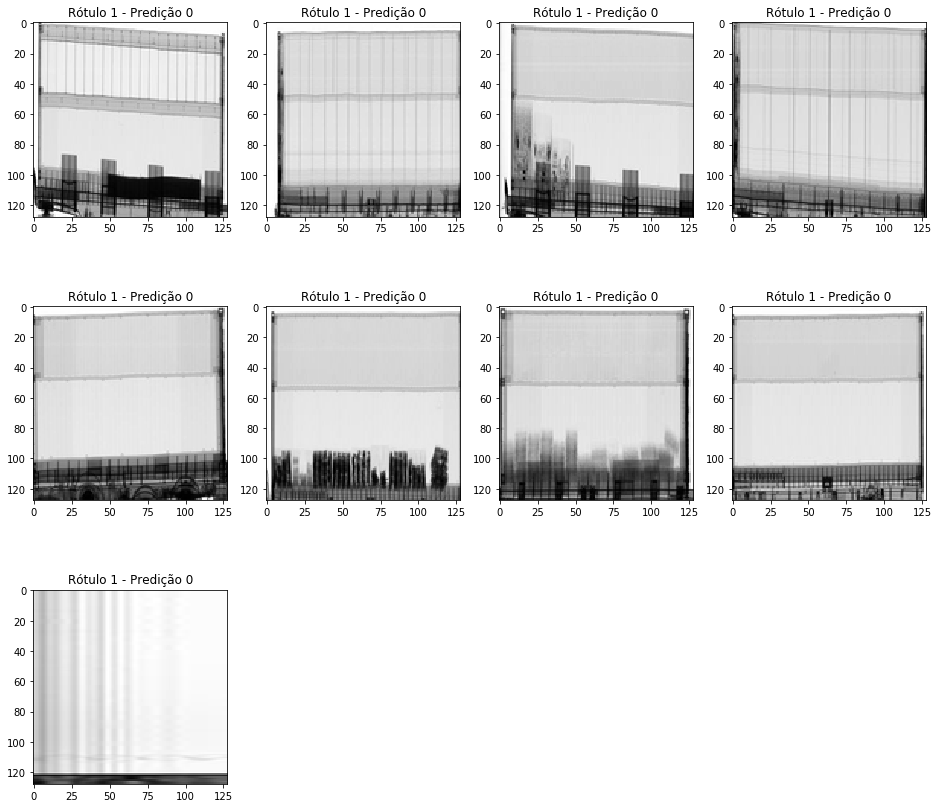

In [53]:
plt.gray()
fig=plt.figure(figsize=(16, 20))
for i, line in enumerate(error_indexes):
    img = np.asarray(X_test.iloc[line]).reshape(128, 128)
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_title('Rótulo %d - Predição %d' % (y_test.iloc[line], y_pred[line]))
    plt.imshow(img)
plt.show()

# Salvar resultados

In [55]:
joblib.dump(svm_estimator, 'SVCVazio.pkl')

['SVCVazio.pkl']

In [ ]:
from sklearn.pipeline import Pipeline


# KFold cross validation dos parâmetros do GridSearchCV

In [39]:
Xt = np.asarray(X)
yt = np.asarray(y)

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
print(skf.get_n_splits(Xt, yt))
print(Xt.shape, yt.shape)
ksvc = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001)


5
(5234, 16384) (5234,)


In [44]:
index = 1
mean_accuracy = 0
for train_index, test_index in skf.split(Xt, yt):
    print('StratifiedKFold %d ' % index)
    print("TRAIN: %d TEST: % d" % (len(train_index), len(test_index)))
    X_train, y_train = Xt[train_index], yt[train_index]
    ksvc.fit(X_train, y_train)
    X_test, y_test = Xt[test_index], yt[test_index]
    y_pred_kfold = ksvc.predict(X_test)
    print(metrics.classification_report(y_test, y_pred_kfold))
    accuracy = metrics.accuracy_score(y_test, y_pred_kfold)
    mean_accuracy += accuracy
    print(accuracy)
    index +=1
    
mean_accuracy = mean_accuracy / 5
print('Mean accuracy %f' % mean_accuracy)

StratifiedKFold 1 
TRAIN: 4186 TEST:  1048
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       468
          1       1.00      1.00      1.00       580

avg / total       1.00      1.00      1.00      1048

0.9990458015267175
StratifiedKFold 2 
TRAIN: 4187 TEST:  1047
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       468
          1       1.00      1.00      1.00       579

avg / total       1.00      1.00      1.00      1047

0.9980897803247374
StratifiedKFold 3 
TRAIN: 4187 TEST:  1047
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       468
          1       1.00      0.99      0.99       579

avg / total       0.99      0.99      0.99      1047

0.9923591212989494
StratifiedKFold 4 
TRAIN: 4188 TEST:  1046
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       467
          1       1

# Recarrega modelo anteriormente treinado

In [45]:
from sklearn import svm, metrics
from sklearn.externals import joblib

In [46]:
clf_loadtest = joblib.load('SVCVazio.pkl')

In [47]:
y_pred_load = clf_loadtest.predict(X_test)

In [48]:
print(metrics.classification_report(y_pred_load, y_test))

             precision    recall  f1-score   support

          0       1.00      0.99      1.00       470
          1       0.99      1.00      1.00       576

avg / total       1.00      1.00      1.00      1046



## Validar melhora em relação ao modelo anterior

### Primeiro, checar erro tipo I (precisão) - Rótulo 1 previsto para rótulo "correto"(declarado) 0
### (Pode ser também erro de base, questão operacional,equipamentos do Armador como genset, ou fraude aduaneira, portanto deve ser objeto de inspeção visual

### Após, checar erro tipo II (recall) - Rótulo previsto como 0 e declarado como 1
### Idem sobre a necessidade de inspeção visual

In [6]:
import numpy as np
from PIL import Image
from pymongo import MongoClient

from ajna_commons.flask.conf import DATABASE, MONGODB_URI
from ajna_commons.utils.images import get_imagens_recortadas

db = MongoClient(host=MONGODB_URI)[DATABASE]

In [7]:
filtro_tipo1 = {'metadata.carga.vazio': True,
                'metadata.predictions.vazio': False}
          
filtro_tipo2 = {'metadata.carga.vazio': False,
                'metadata.predictions.vazio': True}


def get_cursor_filtrado(db, filtro):
    cursor = db['fs.files'].find(filtro)
    return cursor


In [8]:
def get_id_eimagens(db, filtro):
    cursor = get_cursor_filtrado(db, filtro)
    lista = []
    for linha in cursor:
        _id = linha['_id']
        imagens = [(_id, im) for im in get_imagens_recortadas(db, _id)]
        for idimagem in imagens:
            lista.append(idimagem)
    return lista

In [74]:
lista = get_id_eimagens(db, filtro_tipo1)

In [75]:
print(len(lista))

1580


In [1]:
def salva_imagens(dir_name, lista):
    try:
        os.mkdir(dir_name)
    except FileExistsError:
        pass
    for idimage in lista:
        filename = str(idimage[0]) + '.jpg'
        idimage[1].save(os.path.join(dir_name, filename))

In [81]:
salva_imagens('vaziosdificeis', lista)

In [54]:
SIZE = 128, 128

def image_array2(idimages):
    result = []
    for idimage in idimages:
        # image = Image.open(filename)
        image = idimage[1]
        image = image.resize(SIZE, Image.ANTIALIAS)
        image_array = np.asarray(image).astype('float32')
        image_array = image_array[:, :, 0] / 255
        del image
        result.append(image_array)
    return result



In [55]:
X = image_array2(lista)
X = np.asarray(X)
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
print(X.shape)
_ids_test1 = [idimage[0] for idimage in lista]
y_test1 = np.linspace(0, 0, X.shape[0])

(1580, 16384)


In [56]:
y_pred = clf_loadtest.predict(X)
print(metrics.classification_report(y_test1, y_pred))

             precision    recall  f1-score   support

        0.0       1.00      0.97      0.98      1580
        1.0       0.00      0.00      0.00         0

avg / total       1.00      0.97      0.98      1580



/home/ivan/pybr/ajna_docs/padma/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Linha 30, rótulo 0, predição 1, arquivo 5aa1e1432a87950ba6abdbf3
Linha 32, rótulo 0, predição 1, arquivo 5aa1e1482a87950ba4abf9ac
Linha 34, rótulo 0, predição 1, arquivo 5aa1e2232a87950ba4ac0a47
Linha 35, rótulo 0, predição 1, arquivo 5aa1e2232a87950ba5abe5ee
Linha 58, rótulo 0, predição 1, arquivo 5aa1e3f52a87950ba6ac2d11
Linha 63, rótulo 0, predição 1, arquivo 5aa1e6a62a87950ba6ac488a
Linha 73, rótulo 0, predição 1, arquivo 5aa1a51e2a87954aaedda418
Linha 87, rótulo 0, predição 1, arquivo 5aa1d5cb2a87950258b18881
Linha 98, rótulo 0, predição 1, arquivo 5aa1e1442a87950ba5abde93
Linha 105, rótulo 0, predição 1, arquivo 5aa1e7872a87950ba6ac68b9
Linha 127, rótulo 0, predição 1, arquivo 5aa1a7752a87954aaeddaf65
Linha 129, rótulo 0, predição 1, arquivo 5aa18b7f2a87953d7d02a70a
Linha 132, rótulo 0, predição 1, arquivo 5aa18c8f2a87953ebf575967
Linha 141, rótulo 0, predição 1, arquivo 5aa1a5332a87954aaeddab64
Linha 142, rótulo 0, predição 1, arquivo 5aa1a5332a87954aaeddab58
Linha 143, rótulo 0

<Figure size 432x288 with 0 Axes>

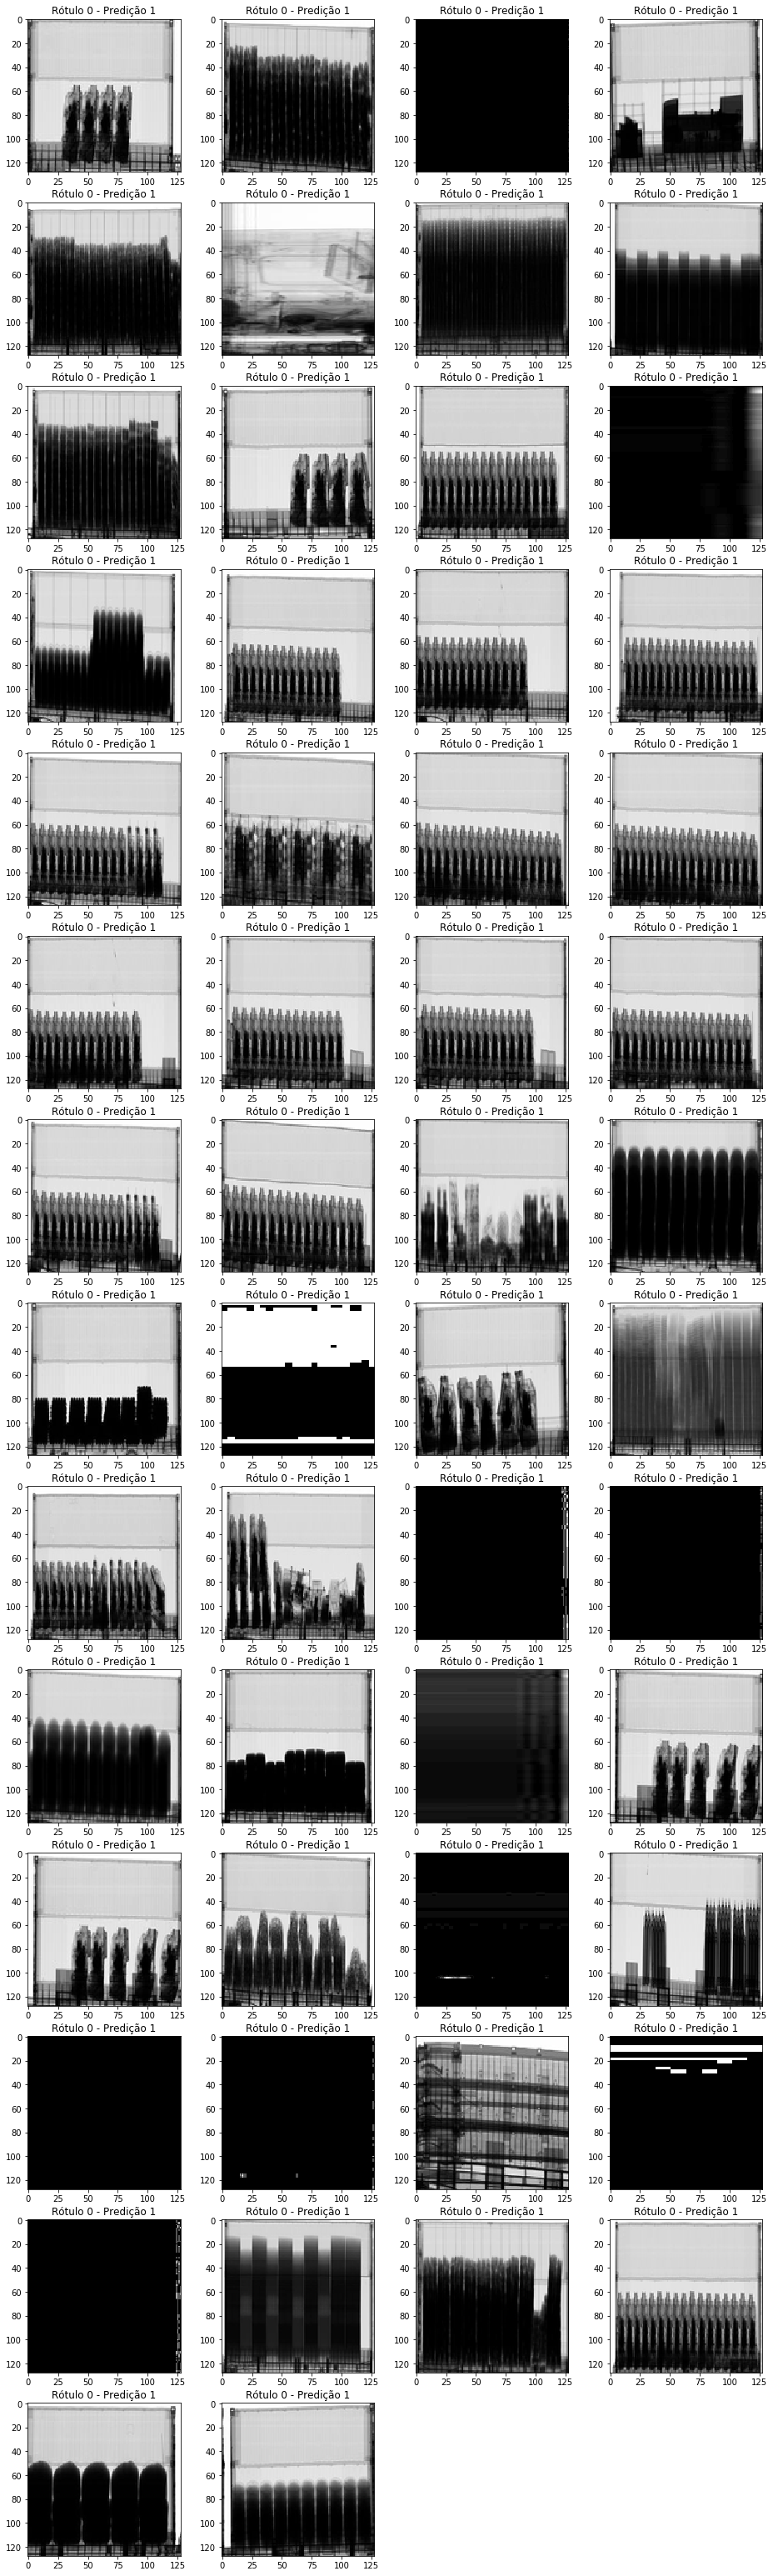

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
error_indexes = []
for index, (y, y_, _id) in enumerate(zip(y_test1, y_pred, _ids_test1)):
    if y != y_:
        print('Linha %d, rótulo %d, predição %d, arquivo %s' %  (index, y, y_, _id))
        error_indexes.append(index)
print(len(error_indexes))
linhas = len(error_indexes) // 4 + 1
plt.gray()
fig=plt.figure(figsize=(16, 4*linhas))
for i, line in enumerate(error_indexes):
    img = np.asarray(X[line]).reshape(128, 128)
    ax = fig.add_subplot(linhas, 4, i + 1)
    ax.set_title('Rótulo %d - Predição %d' % (y_test1[line], y_pred[line]))
    plt.imshow(img)
plt.show()

In [9]:
lista = get_id_eimagens(db, filtro_tipo2)

In [10]:
print(len(lista))

1742


In [11]:
salva_imagens('naovaziosdificeis', lista)

In [60]:
X2 = image_array2(lista)
X2 = np.asarray(X2)
X2 = X2.reshape(X2.shape[0], X2.shape[1]*X2.shape[2])
print(X2.shape)
_ids_test2 = [idimage[0] for idimage in lista]
y_test2 = np.linspace(1, 1, X2.shape[0])

(1742, 16384)


In [61]:
y_pred2 = clf_loadtest.predict(X2)
print(metrics.classification_report(y_test2, y_pred2))

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         0
        1.0       1.00      0.23      0.38      1742

avg / total       1.00      0.23      0.38      1742



/home/ivan/pybr/ajna_docs/padma/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
error_indexes = []
for index, (y, y_, _id) in enumerate(zip(y_test2, y_pred2, _ids_test2)):
    if y != y_:
        print('Linha %d, rótulo %d, predição %d, arquivo %s' %  (index, y, y_, _id))
        error_indexes.append(index)
print(len(error_indexes))

Linha 0, rótulo 1, predição 0, arquivo 5aa1cc482a87957e63f4b787
Linha 2, rótulo 1, predição 0, arquivo 5aa1cc5d2a87957e62f4b938
Linha 3, rótulo 1, predição 0, arquivo 5aa1cc602a87957e62f4b978
Linha 4, rótulo 1, predição 0, arquivo 5aa1cc732a87957e63f4ba9f
Linha 5, rótulo 1, predição 0, arquivo 5aa1cc7c2a87957e60f49bc6
Linha 6, rótulo 1, predição 0, arquivo 5aa1cc7e2a87957e60f49bf6
Linha 7, rótulo 1, predição 0, arquivo 5aa1cc862a87957e64f4acb3
Linha 9, rótulo 1, predição 0, arquivo 5aa1cc9a2a87957e60f49dfa
Linha 10, rótulo 1, predição 0, arquivo 5aa1d2252a879501d78cbe68
Linha 12, rótulo 1, predição 0, arquivo 5aa1d32e2a87950257b1757e
Linha 14, rótulo 1, predição 0, arquivo 5aa1d3372a8795025ab1766a
Linha 17, rótulo 1, predição 0, arquivo 5aa1d3702a87950257b17dee
Linha 18, rótulo 1, predição 0, arquivo 5aa1d3722a8795025ab17e32
Linha 19, rótulo 1, predição 0, arquivo 5aa1d37e2a8795025ab17fc6
Linha 21, rótulo 1, predição 0, arquivo 5aa1d48d2a87950258b17832
Linha 23, rótulo 1, predição 0, a

<Figure size 432x288 with 0 Axes>

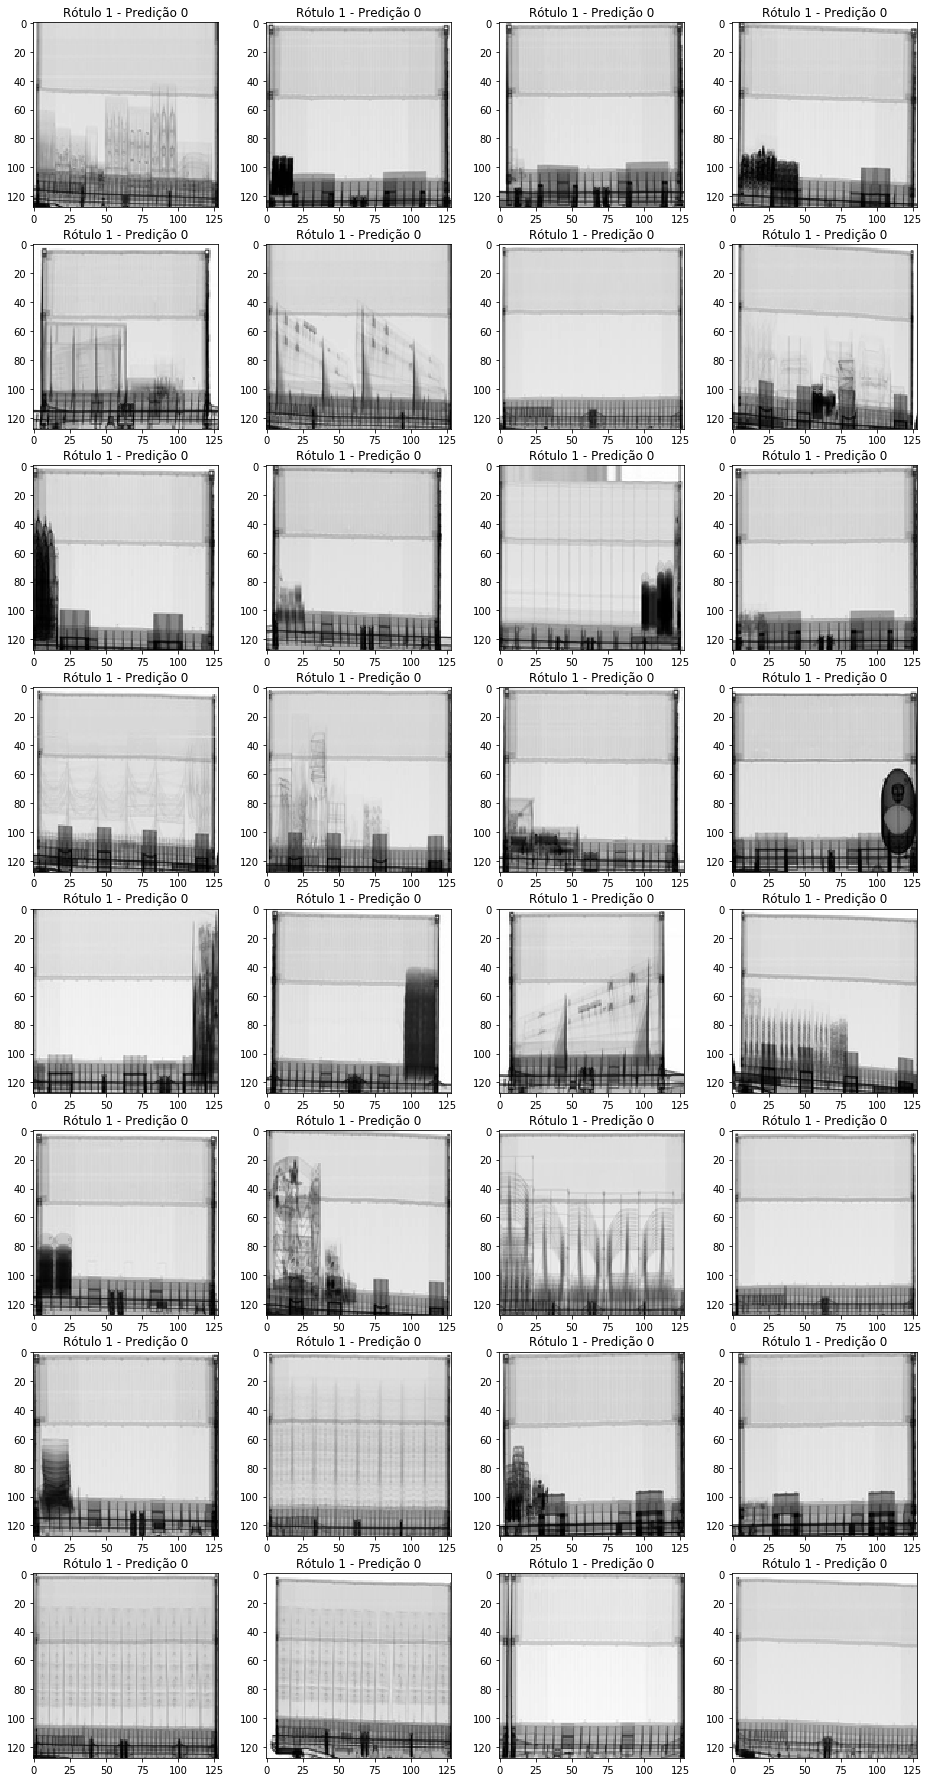

In [63]:
linhas = len(error_indexes[:32]) // 4 + 1
plt.gray()
fig=plt.figure(figsize=(16, 4*linhas))
for i, line in enumerate(error_indexes[:32]):
    img = np.asarray(X2[line]).reshape(128, 128)
    ax = fig.add_subplot(linhas, 4, i + 1)
    ax.set_title('Rótulo %d - Predição %d' % (y_test2[line], y_pred2[line]))
    plt.imshow(img)
plt.show()

In [67]:
X_dificeis = np.concatenate((X, X2), axis=0)
y_pred_d = clf_loadtest.predict(X_dificeis)

In [73]:
y_dificeis = np.concatenate((y_test1, y_test2), axis=0)
print(metrics.classification_report(y_dificeis, y_pred_d))
print(metrics.confusion_matrix(y_dificeis, y_pred_d))

             precision    recall  f1-score   support

        0.0       0.53      0.97      0.69      1580
        1.0       0.88      0.23      0.37      1742

avg / total       0.72      0.58      0.52      3322

[[1526   54]
 [1336  406]]
